# Деревья решений 
В этом задании предстоит реализовать очень полезный метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений. Кроме того, этот метод часто используется в случаях, когда интерпретируемость модели имеет большое значение, например, в чувствительных задачах 

In [6]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib

Основная идея любого алгоритма дерева решений заключается в следующем: 
1. Выберите лучший атрибут, используя меры выбора атрибута (ASM), чтобы разделить примеры. 
2.  Сделайте этот атрибут узлом решения и разбейте набор данных на более мелкие подмножества. 
3. Начните построение дерева, рекурсивно повторяя этот процесс для каждого дочернего элемента, пока не совпадет одно из условий:
   1. Все кортежи принадлежат одному и тому же значению атрибута. 
   2. Оставшихся атрибутов больше нет. 
   3. Больше нет примеров

## Использование различных моделей

Протестируем решение на датасетах [mushrooms](https://www.kaggle.com/datasets/uciml/mushroom-classification) и diabetes?.
1. Выполним загрузку и предобработку данных.
2. Разобьем данные на тренировочный и валидационный набор для оценки точности работы алгоритма.
3. Посчитаем метрики для различных параметров построения дерева

In [7]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
import yaml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [8]:
with open('../config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)

Начнем с WDBC. В этом датасете хранятся геометрические и прочие внешние признаки опухолей (вероятно, полученные из МРТ). Опухоли будут быть доброкачественными (benign = B) и злокачественными (malignant = M). Задача состоит в определении типа опухоли по данным признакам

In [9]:
df = pd.read_csv("../wdbc.tar/data.csv")

Как обычно, отбрасываем идентификатор

In [10]:
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Трансформируем строковые категории B и M в числовые 0 и 1, после чего разделяем признаки и таргет, который будем предсказывать. Это дает нам датафреймы X и y соответственно.

In [11]:
df['diagnosis'] = df['diagnosis'].replace({'B': 0, 'M': 1}).astype(int)
target = 'diagnosis'
features = list(df.columns)
features.remove('diagnosis')
features

C:\Users\Romchik\AppData\Local\Temp\ipykernel_26116\3186978791.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'] = df['diagnosis'].replace({'B': 0, 'M': 1}).astype(int)


['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [12]:
X_diagnosis = df[features]
y_diagnosis = df[[target]]

Рассмотрим теперь датасет mushrooms. В нем содержатся геометрические и прочие внешние признаки грибов, которые классифицируются на съедобные и ядовитые. Наша задача состоит в подобной классификации по данным признакам

In [16]:
df = pd.read_csv("../mushrooms.tar/mushrooms.csv")
target = 'class'
features = list(df.columns)
features.remove(target)
X_mushroom = df[features]
y_mushroom = df[[target]]
X_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


**Задание**: Проведите краткий EDA. Есть ли выбросы в данных, как связаны столбцы? Хватит 2-3 графиков или таблиц (но можно больше). Какие есть типы признаков в этом датасете?


Основная статистика по категориям:

class:
class
e    0.517971
p    0.482029
Name: proportion, dtype: float64

cap-shape:
cap-shape
x    0.450025
f    0.387986
k    0.101920
b    0.055638
s    0.003939
c    0.000492
Name: proportion, dtype: float64

cap-surface:
cap-surface
y    0.399311
s    0.314623
f    0.285574
g    0.000492
Name: proportion, dtype: float64

cap-color:
cap-color
n    0.281142
g    0.226489
e    0.184638
y    0.131955
w    0.128016
b    0.020679
p    0.017725
c    0.005416
u    0.001969
r    0.001969
Name: proportion, dtype: float64

bruises:
bruises
f    0.584441
t    0.415559
Name: proportion, dtype: float64

odor:
odor
n    0.434269
f    0.265879
s    0.070901
y    0.070901
a    0.049237
l    0.049237
p    0.031512
c    0.023634
m    0.004431
Name: proportion, dtype: float64

gill-attachment:
gill-attachment
f    0.974151
a    0.025849
Name: proportion, dtype: float64

gill-spacing:
gill-spacing
c    0.838503
w    0.161497
Name: proportion, dtype: float64

gill-

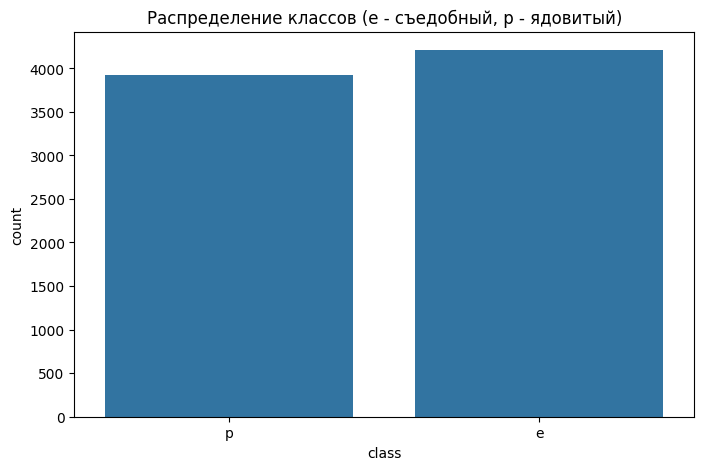

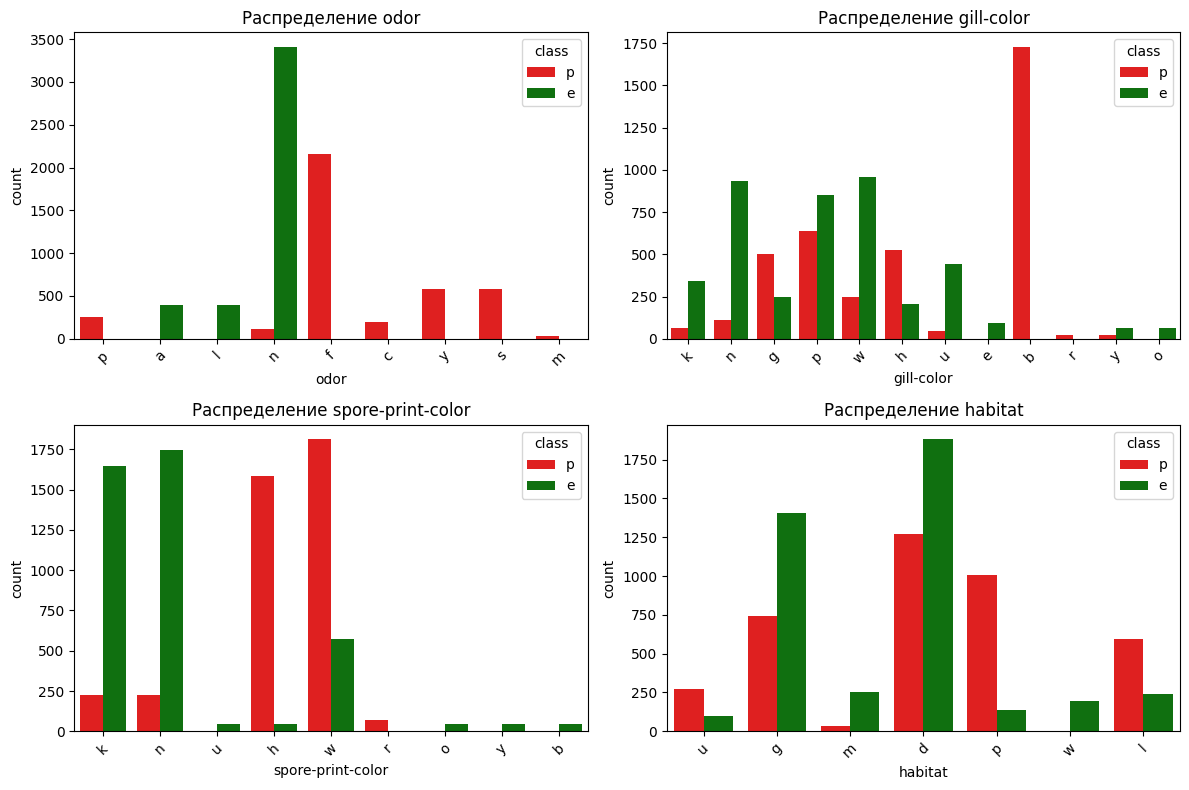

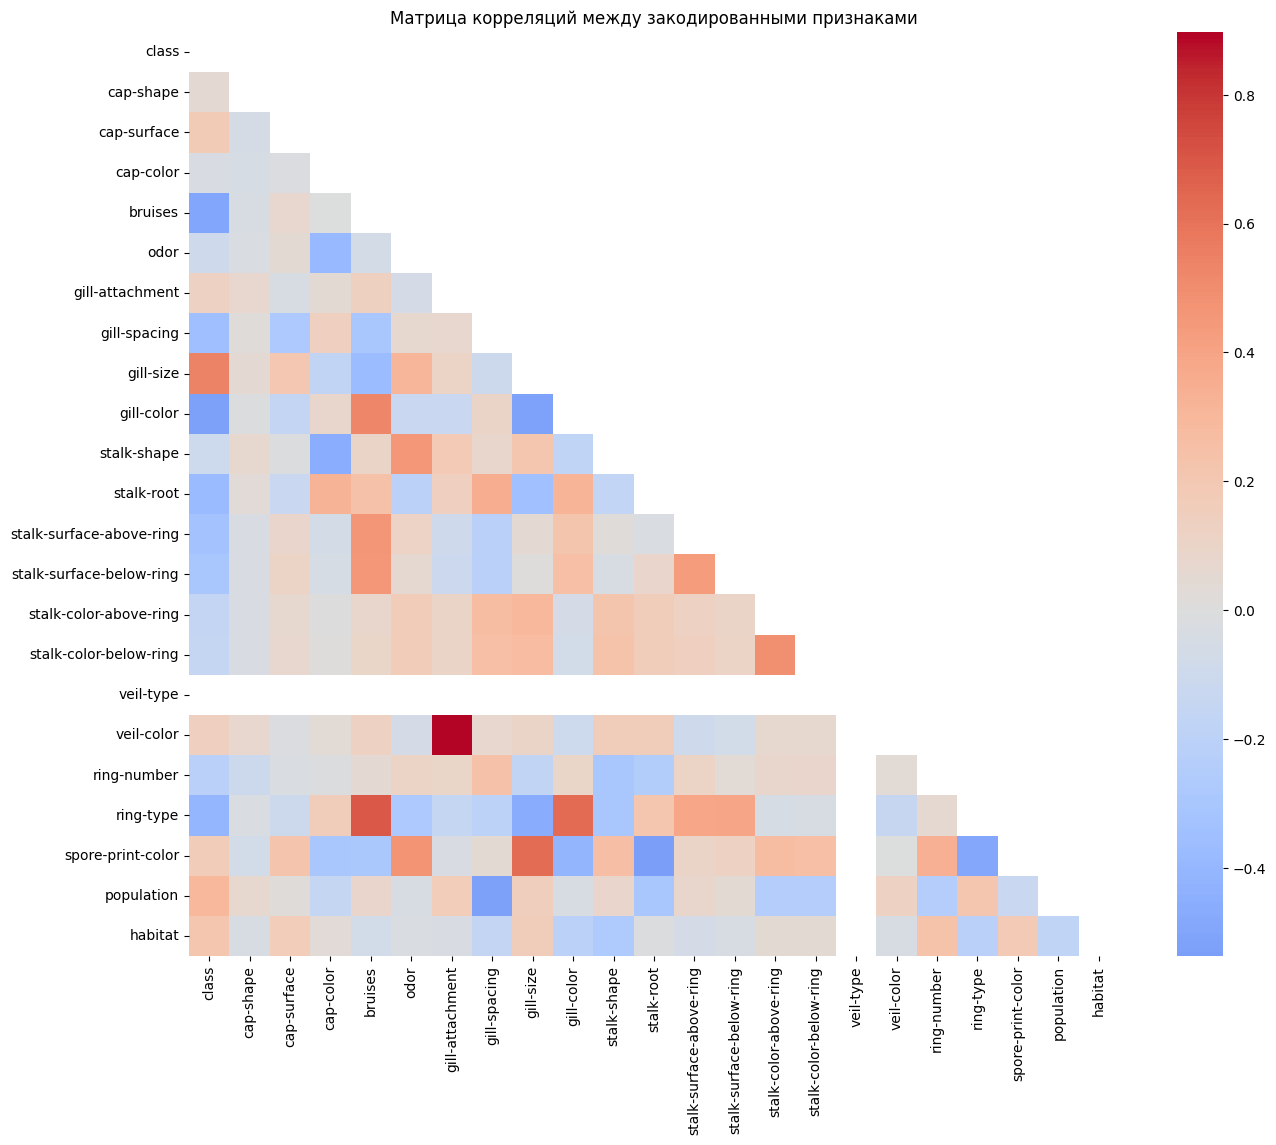

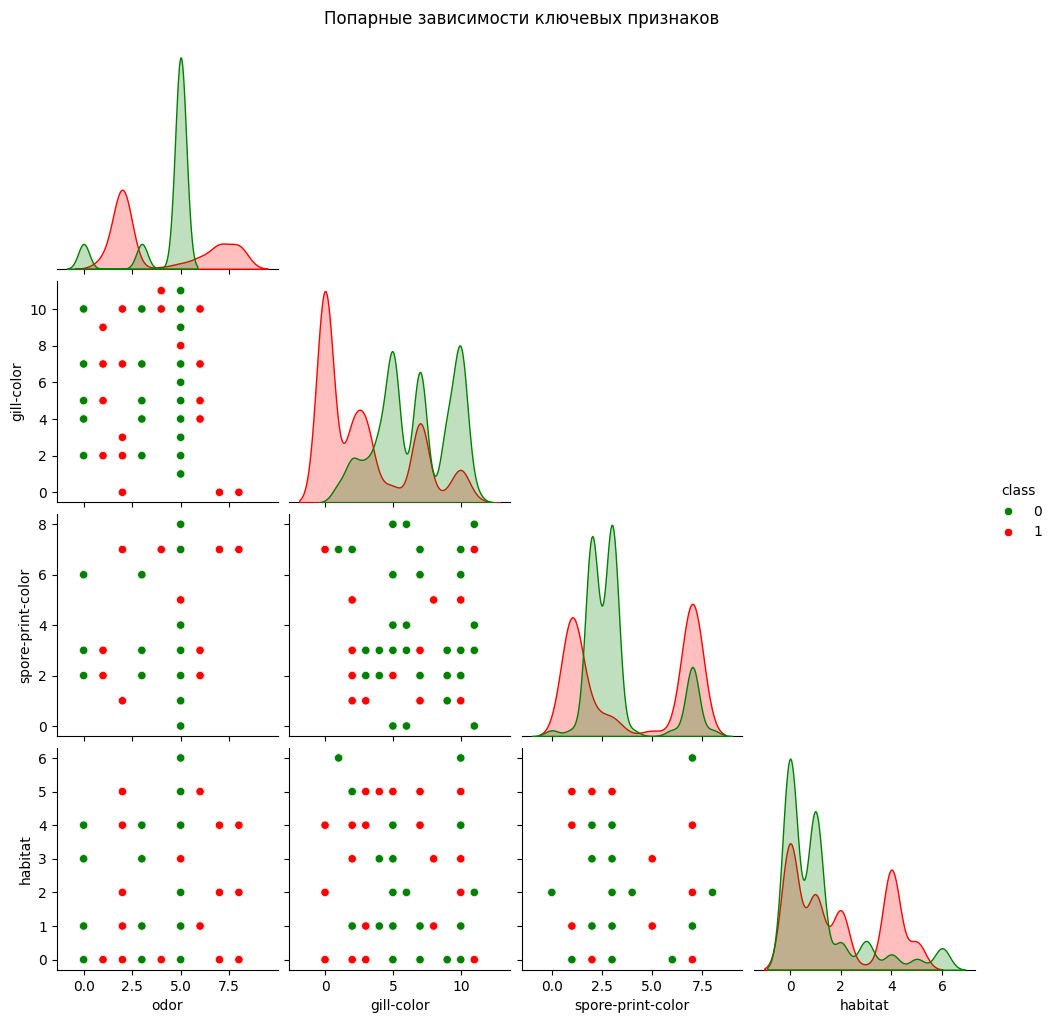

In [17]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print("\nОсновная статистика по категориям:")
for col in df.columns:
    print(f"\n{col}:")
    print(df[col].value_counts(normalize=True))

plt.figure(figsize=(8,5))
sns.countplot(x='class', data=df)
plt.title('Распределение классов (e - съедобный, p - ядовитый)')
plt.show()

key_features = ['odor', 'gill-color', 'spore-print-color', 'habitat']
plt.figure(figsize=(12,8))
for i, feature in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=feature, hue='class', palette={'e':'green', 'p':'red'})
    plt.title(f'Распределение {feature}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)

plt.figure(figsize=(15,12))
corr = df_encoded.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0,
            mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title('Матрица корреляций между закодированными признаками')
plt.show()

# 5. Анализ парных взаимосвязей для ключевых признаков
sns.pairplot(df_encoded[key_features + ['class']], hue='class', 
             palette={1:'red', 0:'green'}, corner=True)
plt.suptitle('Попарные зависимости ключевых признаков', y=1.02)
plt.show()

In [18]:
import category_encoders as ce

encoder = ce.CountEncoder()
X_mushroom = encoder.fit_transform(X_mushroom)
X_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,3656,2556,2284,3376,256,7914,6812,2512,408,3516,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
1,3656,2556,1072,3376,400,7914,6812,5612,408,3516,...,4936,4464,4384,8124,7924,7488,3968,1968,400,2148
2,452,2556,1040,3376,400,7914,6812,5612,1048,3516,...,4936,4464,4384,8124,7924,7488,3968,1968,400,292
3,3656,3244,1040,3376,256,7914,6812,2512,1048,3516,...,4936,4464,4384,8124,7924,7488,3968,1872,1248,368
4,3656,2556,1840,4748,3528,7914,1312,5612,408,4608,...,4936,4464,4384,8124,7924,7488,2776,1968,384,2148


In [19]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_mushroom = encoder.fit_transform(y_mushroom)

c:\artificial_intelligence\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Теперь перейдем к предсказанию типа опухолей с помощью деревьев решений.

Проведем train/test сплит

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=1)

In [21]:
y_train

,diagnosis
408,1
4,1
307,0
386,0
404,0
...,...
129,1
144,0
72,1
235,0


Поэкспериментируем с деревом решений из библиотеки sklearn. 

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)

In [ ]:
tree.predict_proba(X_test)[:, 1]

In [25]:
tree.score(X_test, y_test)
#metrics.roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])

0.8421052631578947

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree, ax=ax)

Рассмотрим другие значения гиперпараметров

In [ ]:
tree_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree_gini.fit(X_train, y_train), ax=ax)

In [28]:
print('Training-set accuracy score: {0:0.4f}'. format(tree_gini.score(X_train, y_train)))
print('Test-set accuracy score: {0:0.4f}'. format(tree_gini.score(X_test, y_test)))

Training-set accuracy score: 0.9692
Test-set accuracy score: 0.9123


Попробуем вместо Джини использовать энтропию

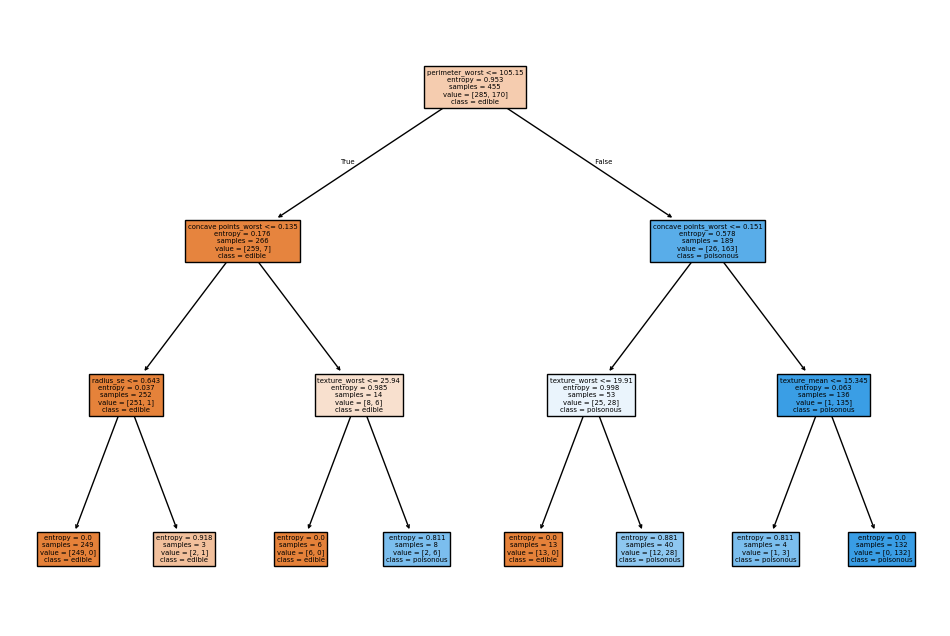

Training-set accuracy score (Entropy): 0.9648
Test-set accuracy score (Entropy): 0.9123


In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

tree_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree_entropy.fit(X_train, y_train)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plot_tree(tree_entropy, ax=ax, feature_names=X_train.columns, class_names=['edible', 'poisonous'], filled=True)
plt.show()

# Оценка производительности
print('Training-set accuracy score (Entropy): {0:0.4f}'.format(tree_entropy.score(X_train, y_train)))
print('Test-set accuracy score (Entropy): {0:0.4f}'.format(tree_entropy.score(X_test, y_test)))

Перейдем теперь к датасету с грибами

[Text(0.4666666666666667, 0.9166666666666666, 'x[4] <= 2844.0\ngini = 0.499\nsamples = 6499\nvalue = [3388.0, 3111.0]'),
 Text(0.26666666666666666, 0.75, 'x[10] <= 838.0\ngini = 0.288\nsamples = 3660\nvalue = [637, 3023]'),
 Text(0.3666666666666667, 0.8333333333333333, 'True  '),
 Text(0.13333333333333333, 0.5833333333333334, 'x[20] <= 370.0\ngini = 0.098\nsamples = 580\nvalue = [550, 30]'),
 Text(0.06666666666666667, 0.4166666666666667, 'gini = 0.0\nsamples = 30\nvalue = [0, 30]'),
 Text(0.2, 0.4166666666666667, 'gini = 0.0\nsamples = 550\nvalue = [550, 0]'),
 Text(0.4, 0.5833333333333334, 'x[6] <= 4062.0\ngini = 0.055\nsamples = 3080\nvalue = [87, 2993]'),
 Text(0.3333333333333333, 0.4166666666666667, 'x[3] <= 4062.0\ngini = 0.495\nsamples = 158\nvalue = [87.0, 71.0]'),
 Text(0.26666666666666666, 0.25, 'gini = 0.0\nsamples = 87\nvalue = [87, 0]'),
 Text(0.4, 0.25, 'gini = 0.0\nsamples = 71\nvalue = [0, 71]'),
 Text(0.4666666666666667, 0.4166666666666667, 'gini = 0.0\nsamples = 2922\n

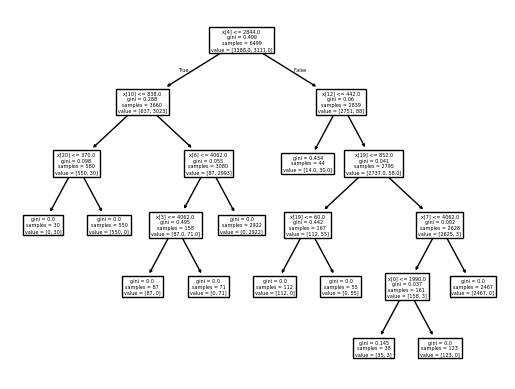

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_mushroom, y_mushroom, test_size=0.2, random_state=1)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
plot_tree(tree.fit(X_train, y_train))

In [31]:
y_pred_train = tree.predict(X_train)
y_pred_test = tree.predict(X_test)
print('Training-set accuracy score: {0:0.4f}'. format(tree.score(X_train, y_train)))
print('Test-set accuracy score: {0:0.4f}'. format(tree.score(X_test, y_test)))

Training-set accuracy score: 0.9974
Test-set accuracy score: 0.9957


Сравним, как разные классификаторы строят границы разделения. Для начала посмотрим на общую картинку, как в зависимости от настроек будет отличаться дерево.

In [32]:
classifiers = {
    "DT_basic_3": DecisionTreeClassifier(max_depth=3),
    "DT_basic_5_no_min": DecisionTreeClassifier(max_depth=5),
    "DT_basic_5": DecisionTreeClassifier(max_depth=5, min_samples_leaf=30),
    "DT_gini_3": DecisionTreeClassifier(max_depth=3, criterion='gini',  min_samples_leaf=30),
    "DT_gini_5": DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=30),
    "DT_entropy_3": DecisionTreeClassifier(max_depth=3, criterion='entropy', min_samples_leaf=30),
    "DT_entropy_5": DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_leaf=30),
    "DT_entropy_5_no_min": DecisionTreeClassifier(max_depth=5, criterion='entropy'),
}
    

columns =  X_diagnosis.columns[:2] 
columns_mushroom = ['gill-color', 'cap-color']

datasets = [
    (X_diagnosis[columns].to_numpy(), y_diagnosis.to_numpy()),
    (X_mushroom[columns_mushroom].to_numpy(), y_mushroom),
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1)
]


In [34]:
def set_grid(ax, i, j, x_min, x_max, y_min, y_max):
    ax[i][j].set_xlim(x_min, x_max)
    ax[i][j].set_ylim(y_min, y_max)
    ax[i][j].set_xticks(())
    ax[i][j].set_yticks(())

In [ ]:
fig, ax = plt.subplots(len(datasets), len(classifiers)+1, figsize=(15, 10))

for dataset_num, data in enumerate(datasets):
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.3, random_state=42
      )
    diff_x = X_train[:, 0].max() - X_train[:, 0].min()
    diff_y = X_train[:, 1].max() - X_train[:, 1].min()
    x_min, x_max = X_train[:, 0].min() - diff_x*0.1, X_train[:, 0].max() + diff_x*0.1
    y_min, y_max = X_train[:, 1].min() - diff_y*0.1, X_train[:, 1].max() + diff_y*0.1


    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    if dataset_num == 0:
          ax[dataset_num][0].set_title("Input data")
            
    # Plot the training points
    ax[dataset_num][0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax[dataset_num][0].scatter(
      X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    set_grid(ax, dataset_num, 0, x_min, x_max, y_min, y_max)
    
    # iterate over classifiers
    for cls_num, (name, clf) in enumerate(classifiers.items(), start=1):
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X_train, cmap=cm, alpha=0.8, ax=ax[dataset_num][cls_num], eps=0.5
        )
        
        # Plot the training points
        #ax[dataset_num][cls_num].scatter(
        #    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        #)
        
        # Plot the testing points
        ax[dataset_num][cls_num].scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        set_grid(ax, dataset_num, cls_num, x_min, x_max, y_min, y_max)
        if dataset_num == 0:
            ax[dataset_num][cls_num].set_title(name, fontdict={'fontsize': 10, 'fontweight': 'medium'})
            
        ax[dataset_num][cls_num].text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )

plt.tight_layout()
plt.show()

Деревья решений легко переобучаются. В теории, каждая точка набора может сформировать листовую вершину. Поэтому всегда надо аккуратно выбирать гиперпараметры, влияющие на разбиение дерева. Кроме того, деревья чувствительны к обучающе выборке. Даже небольшая ее пертурбация может привести к очень серьезным изменениям в классификаторе.

**Задание**: 
1) Постройте несколько графиков, чтобы оценить, как будет выглядить разделение плоскости в зависимости от 
    - минимального количества объектов в листе
    - максимальной глубины дерева
  К увеличению или уменьшению качества на обучающей выборке приводит увеличение глубины дерева? А на тестовой? 
2) Постройте несколько графиков, чтобы оценить, как будет выглядить разделение плоскости в зависимости от подвыборки. Выберите из вашего обучающего набора 90% семплов с разными сидами и посмотрите, как поменяются предсказания.

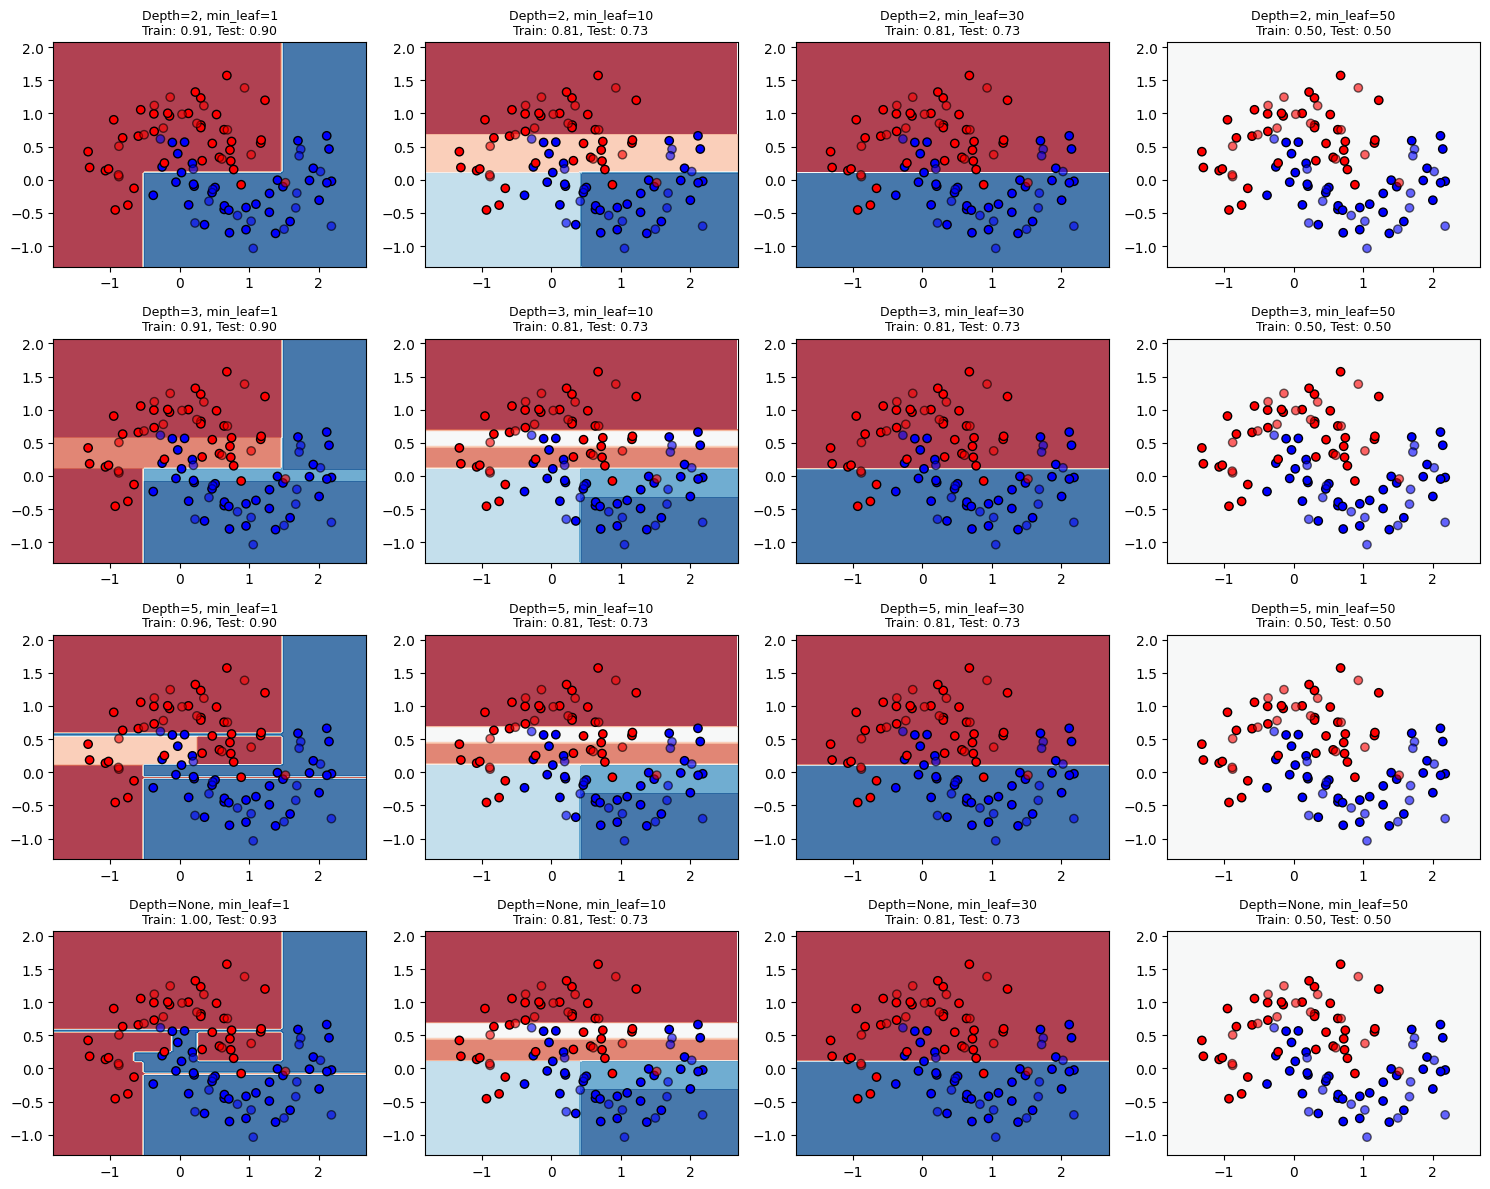

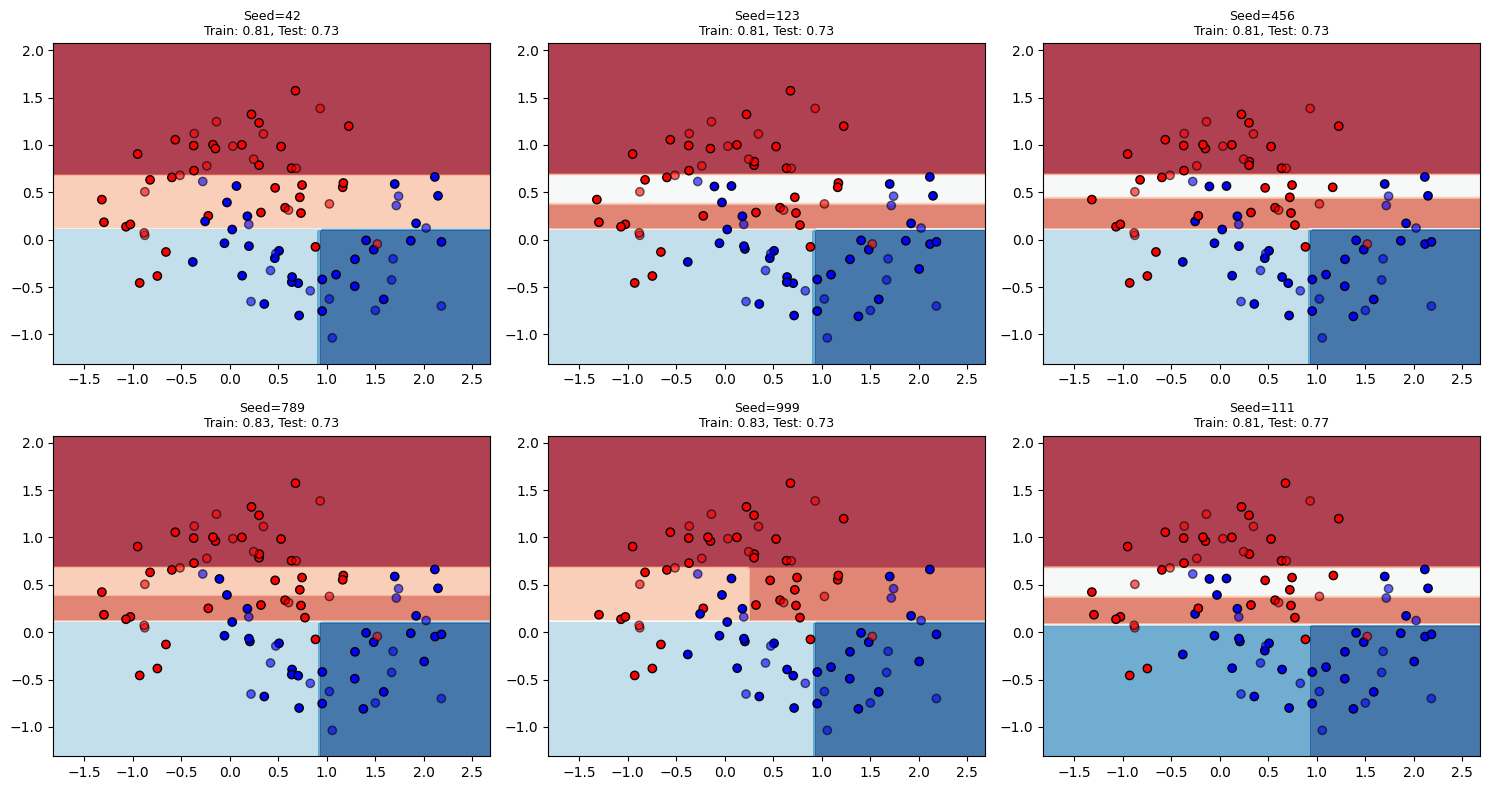

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

X, y = make_moons(noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
max_depths = [2, 3, 5, None]
min_samples_leafs = [1, 10, 30, 50]

fig, axes = plt.subplots(len(max_depths), len(min_samples_leafs), figsize=(15, 12))
cm = plt.cm.RdBu

for i, max_depth in enumerate(max_depths):
    for j, min_samples_leaf in enumerate(min_samples_leafs):
        clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        clf.fit(X_train, y_train)
    
        DecisionBoundaryDisplay.from_estimator(
            clf, X_train, cmap=cm, alpha=0.8, ax=axes[i,j], eps=0.5
        )
        
        axes[i,j].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
        axes[i,j].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)
        
        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        
        axes[i,j].set_title(f"Depth={max_depth}, min_leaf={min_samples_leaf}\nTrain: {train_score:.2f}, Test: {test_score:.2f}", 
                          fontsize=9)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
seeds = [42, 123, 456, 789, 999, 111]

for i, seed in enumerate(seeds[:6]):
    X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=0.9, random_state=seed)
    
    clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, random_state=42)
    clf.fit(X_sub, y_sub)
    
    ax = axes[i//3, i%3]
    DecisionBoundaryDisplay.from_estimator(
        clf, X_train, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )
    
    ax.scatter(X_sub[:, 0], X_sub[:, 1], c=y_sub, cmap=cm_bright, edgecolors="k")
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors="k", alpha=0.6)
    
    train_score = clf.score(X_sub, y_sub)
    test_score = clf.score(X_test, y_test)
    
    ax.set_title(f"Seed={seed}\nTrain: {train_score:.2f}, Test: {test_score:.2f}", fontsize=9)

plt.tight_layout()
plt.show()

**Задание:**
  Для датасета mushrooms сравните, как меняется точность и переобучение для деревьев с разными кодировками признаков. Можете зафиксировать остальные параметры. 

In [39]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

X = df.drop('class', axis=1)
y = df['class'].apply(lambda x: 1 if x == 'p' else 0) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

encoders = {
    'LabelEncoder': LabelEncoder(),
    'OrdinalEncoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'OneHotEncoder': OneHotEncoder(handle_unknown='ignore', sparse_output=False)
}

results = {'Encoder': [], 'Train Accuracy': [], 'Test Accuracy': [], 'Overfitting (Diff)': []}

tree_params = {'max_depth': 5, 'min_samples_leaf': 10, 'random_state': 42}

for enc_name, encoder in encoders.items():
    if enc_name == 'OneHotEncoder':
        X_train_encoded = encoder.fit_transform(X_train)
        X_test_encoded = encoder.transform(X_test)
    elif enc_name == 'OrdinalEncoder':
        X_train_encoded = encoder.fit_transform(X_train)
        X_test_encoded = encoder.transform(X_test)
    else:  
        encoders_dict = {col: LabelEncoder().fit(X_train[col]) for col in X_train.columns}
        X_train_encoded = X_train.apply(lambda col: encoders_dict[col.name].transform(col))
        X_test_encoded = X_test.apply(lambda col: col.map(lambda x: x if x in encoders_dict[col.name].classes_ else -1))
        X_test_encoded = X_test_encoded.apply(lambda col: encoders_dict[col.name].transform(col))
    
    clf = DecisionTreeClassifier(**tree_params)
    clf.fit(X_train_encoded, y_train)

    train_acc = accuracy_score(y_train, clf.predict(X_train_encoded))
    test_acc = accuracy_score(y_test, clf.predict(X_test_encoded))
    overfitting = train_acc - test_acc

    results['Encoder'].append(enc_name)
    results['Train Accuracy'].append(train_acc)
    results['Test Accuracy'].append(test_acc)
    results['Overfitting (Diff)'].append(overfitting)

# Визуализация результатов
results_df = pd.DataFrame(results).set_index('Encoder')
print(results_df)

                Train Accuracy  Test Accuracy  Overfitting (Diff)
Encoder                                                          
LabelEncoder          0.978720       0.977441            0.001279
OrdinalEncoder        0.978720       0.977441            0.001279
OneHotEncoder         0.999121       0.998769            0.000351
